In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/Workspace/data/emotion-recognition/archive.zip

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [5]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

train_ds_full = ImageFolder(root='train', transform=transform)
train_size = int(0.8 * len(train_ds_full))
val_size = len(train_ds_full) - train_size
train_ds, val_ds = random_split(train_ds_full, [train_size, val_size])

test_ds = ImageFolder(root='test', transform=transform)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

shape: torch.Size([1, 48, 48])


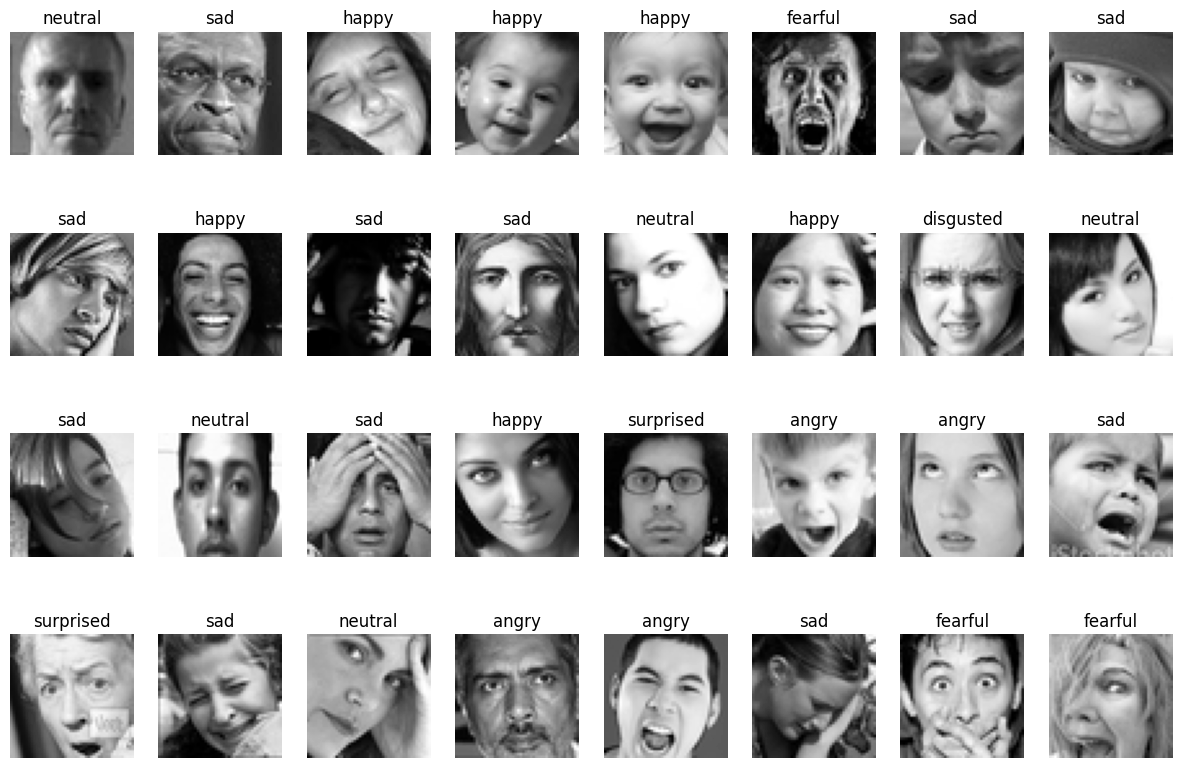

In [6]:
import matplotlib.pyplot as plt

for images, labels in train_dl:
  print('shape:', images[0].shape)

  fig, axes = plt.subplots(4, int(len(images)/4), figsize=(15,10))
  axes = axes.ravel()

  for i in range(len(images)):
    img = images[i].squeeze().numpy()
    label = train_ds_full.classes[labels[i].item()]

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(label)
    axes[i].axis('off')

  plt.show()

  break

shape: torch.Size([1, 48, 48])


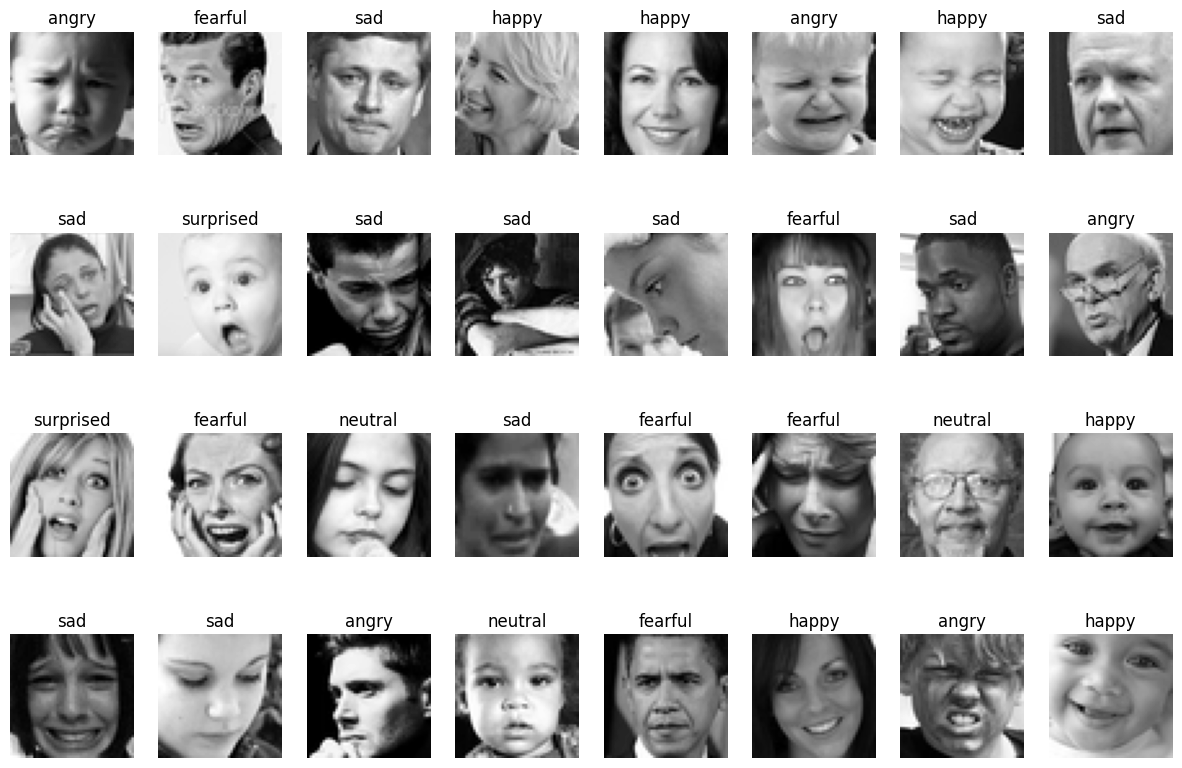

In [7]:
for images, labels in test_dl:
  print('shape:', images[0].shape)

  fig, axes = plt.subplots(4, int(len(images)/4), figsize=(15,10))
  axes = axes.ravel()

  for i in range(len(images)):
    img = images[i].squeeze().numpy()
    label = test_ds.classes[labels[i].item()]

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(label)
    axes[i].axis('off')

  plt.show()

  break

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(128 * 12 * 12, 256)
    self.fc2 = nn.Linear(256, 7)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool(x)

    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.pool(x)

    x = x.view(x.size(0), -1)

    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
)


In [14]:
from tqdm import tqdm

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(4):
  model.train()
  train_loss = 0.0
  for images, labels in tqdm(train_dl, desc=f'Epoch {epoch+1} [Training]'):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_dl)

  model.eval()
  val_loss = 0.0

  with torch.no_grad():
    for images, labels in tqdm(val_dl, desc=f'Epoch {epoch+1} [Validation]'):
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item()

    val_loss /= len(val_dl)

  print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

Epoch 1 [Validation]: 100%|██████████| 180/180 [00:03<00:00, 57.11it/s]


Epoch [1/10], Loss: 1.3819, Val Loss: 1.3657


Epoch 2 [Validation]: 100%|██████████| 180/180 [00:03<00:00, 59.94it/s]


Epoch [2/10], Loss: 0.9374, Val Loss: 1.2266


Epoch 3 [Validation]: 100%|██████████| 180/180 [00:03<00:00, 45.85it/s]


Epoch [3/10], Loss: 0.9257, Val Loss: 1.1619


Epoch 4 [Validation]: 100%|██████████| 180/180 [00:03<00:00, 59.03it/s]

Epoch [4/10], Loss: 1.2314, Val Loss: 1.2160


In [15]:
model.eval()
total_samples = 0
accurate_samples = 0
total_loss = 0.0

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
  for images, labels in test_dl:
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)
    total_loss += loss.item()

    _, predicted = torch.max(outputs, 1)
    total_samples += labels.size(0)
    accurate_samples += (predicted == labels).sum().item()

  avg_loss = total_loss / len(test_dl)
  accuracy = 100.0 * accurate_samples / total_samples

  print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Test Loss: 1.2309, Test Accuracy: 55.77%
